[Total marks: 2.5] Consider the dataset below (1.1). Find MLE estimate for parameters of a neural network for regression with Gaussian Homoskedastic noise, where noise variance has a fixed value = 0.0025. Your model summary should match with (1.2). Animate the MLE fit on the data along with the 95% noise variance intervals [2 marks]. What is the effect of varying the noise variance (only in model, not for regenerating the data) on the MLE fit, show it for 3 different noise variance values? [0.5 mark] Refer to this tutorial for building and training torch.nn models. Use FuncAnimation from matplotlib or Celluloid for animation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
from torchsummary import summary
from IPython.display import HTML



In [2]:
# np.random.seed(0)
# X = np.linspace(0, 1, 100)
# noise = np.random.normal(0, 0.05, 100)
# y = np.sin(2 * np.pi * X) + noise

In [3]:
# plt.plot(X, y, 'o')

In [4]:
np.random.seed(0)
x_values = np.linspace(0, 1, 100)
noise = np.random.normal(0, np.sqrt(0.0025), 100)
y_values = np.sin(2 * np.pi * x_values) + noise
x_values = x_values.reshape(-1, 1)
y_values = y_values.reshape(-1, 1)

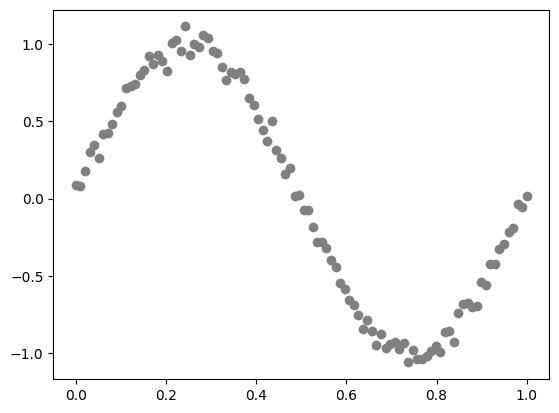

In [5]:
plt.scatter(x_values, y_values, label='Data with Noise', color='gray')


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_tensor = torch.tensor(x_values, dtype=torch.float32, device=device).unsqueeze(1)
y_tensor = torch.tensor(y_values, dtype=torch.float32, device=device).unsqueeze(1)

In [7]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.linear1 = nn.Linear(1, 10)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(10, 10)
        self.selu = nn.SELU()
        self.linear3 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.linear2(x)
        x = self.selu(x)
        x = self.linear3(x)
        return x

model = RegressionModel()        


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

RegressionModel(
  (linear1): Linear(in_features=1, out_features=10, bias=True)
  (gelu): GELU(approximate='none')
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (selu): SELU()
  (linear3): Linear(in_features=10, out_features=1, bias=True)
)

In [9]:
summary(model,(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              20
              GELU-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              SELU-4                   [-1, 10]               0
            Linear-5                    [-1, 1]              11
Total params: 141
Trainable params: 141
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [10]:
loss = nn.GaussianNLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred = model(X_tensor)
    var = torch.full((X_tensor.shape[0], 1), 0.0025, device=device, requires_grad=True)
    output = loss(y_pred, y_tensor, var)
    output.backward()
    optimizer.step()    

with torch.no_grad():
    y_pred = model(X_tensor)
    y_pred = y_pred.cpu().numpy().flatten()

In [32]:
# Define your true function
def true_function(x):
    return np.sin(2 * np.pi * x)

# Create data and Gaussian PDFs
x_values = np.linspace(0, 1, 100)
noise = np.random.normal(0, np.sqrt(0.0025), 100)
y_values = true_function(x_values) + noise

def animate(frame):
    # plt.clf()
    if frame == 0:
        plt.plot(x_values, true_function(x_values),
                 label='True Function', color='tab:blue')
    elif frame == 1:
        plt.plot(x_values, true_function(x_values),
                 color='tab:blue')
        plt.scatter(x_values, y_values, label='Data with Noise', color='gray')
    elif frame == 2:
        plt.plot(x_values, true_function(x_values),
                  color='tab:blue')
        plt.scatter(x_values, y_values, color='gray')         
        plt.plot(x_values, y_pred, 'r', label='MLE Fit')
        plt.fill_between(x_values, y_pred - 2 * np.sqrt(0.0025), y_pred + 2 * np.sqrt(0.0025), color='r', alpha=0.3, label='95% Interval')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

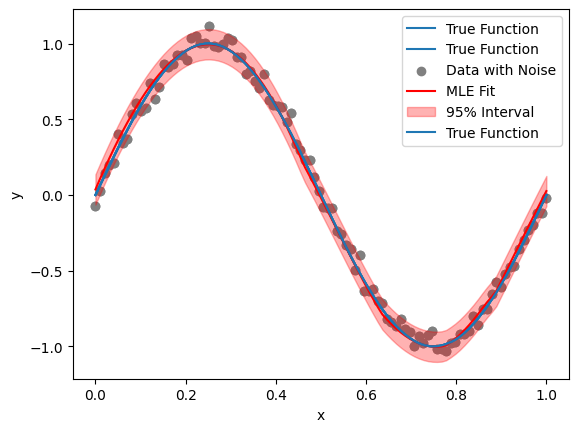

In [33]:
fig = plt.figure()
fig.set_facecolor('white')
anim = FuncAnimation(fig, animate, frames=3, interval=2000, repeat=True)
HTML(anim.to_jshtml())